# PPS Synchronization Error Analysis

The pulse-per-second (PPS) output of a GPS reciever is a 1 Hz clock signal whose rising edge should therotically be aligned exactly with the start of the UTC second. In order to test the accuracy of this signal, the PPS output from two identical recievers was captured and the time difference between the two rising edges was measured. The GPS reciever used was the uBlox MAX-M8Q. Identical antennas were used for each reciever. This test was conducted over a duration of roughly 50 minutes and the setup is shown below.

<img src="./setup.png" width="300"/>

 To begin with lets read in our measurements:

In [2]:
import pandas as pd

# Read CSV File
df = pd.read_csv('./pps-delay-results.csv', names=['Time', 'Delay'])
df.head()

,Time,Delay
0,13:58:23,8.600000e-09
1,13:58:24,-4.600000e-09
2,13:58:25,3.400000e-09
3,13:58:26,1.020000e-08
4,13:58:27,-3.000000e-09


Next lets plot a histogram of the raw data.

<IPython.core.display.Javascript object>


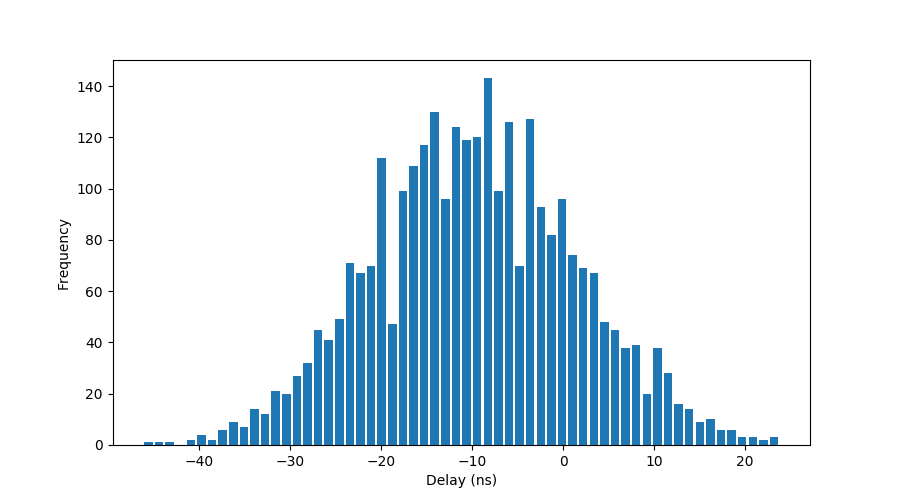

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Generate new figure
fig = plt.figure(figsize=(9, 5))

# Plot Histogram
plt.hist(df['Delay']*1e9, bins=60, rwidth=0.8)
plt.ylabel('Frequency')
plt.xlabel('Delay (ns)')
plt.show()

This is the distribution of the timing error of reciever 2 relative to reciever 1 and takes into account whether the edge came early or late. Clearly there is a tendancy for reciever 2 to lead reciever 1, which could be a result of an internal offset within the recievers. Lets print out some statistics.

In [10]:
# Stats
mx = df['Delay'].max()*1e9
mn = df['Delay'].min()*1e9
avg = df['Delay'].mean()*1e9
std_dev = df['Delay'].std()*1e9

data = [[mn, mx, avg, std_dev]]
df2 = pd.DataFrame(data, ['(ns)'], ['Min', 'Max', 'Avg.', 'Std'])
df2.round(2)

,Min,Max,Avg.,Std
(ns),-46.2,23.8,-9.79,11.17


We are able to calibrate the GPS recievers to remove the tendancy of reciever 2 to lead reciever 1. Lets simulate this here by shifting the distribution.

<IPython.core.display.Javascript object>


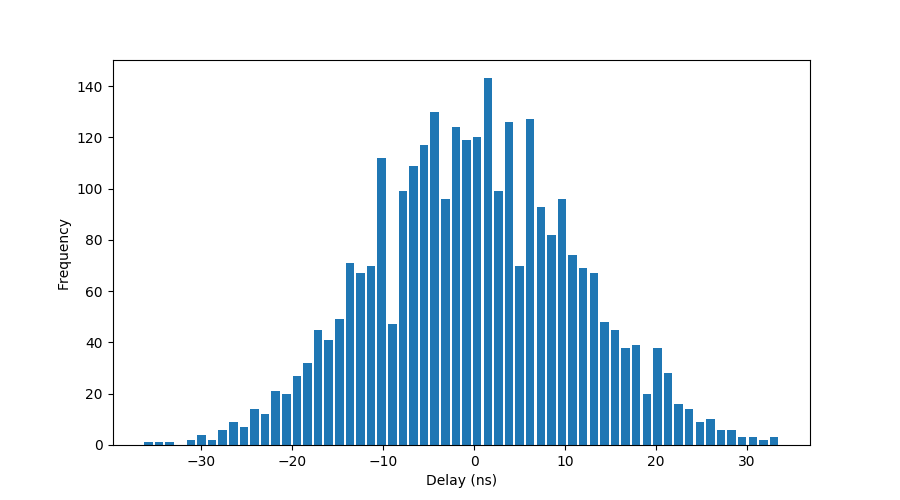

In [12]:
# Shift Distribution
zero_mean = df['Delay'] + 9.79e-9

# Generate new figure
fig = plt.figure(figsize=(9, 5))

# Plot Histogram
plt.hist(zero_mean*1e9, bins=60, rwidth=0.8)
plt.ylabel('Frequency')
plt.xlabel('Delay (ns)')
plt.show()

In [14]:
# Stats
mx = zero_mean.max()*1e9
mn = zero_mean.min()*1e9
avg = zero_mean.mean()*1e9
std_dev = zero_mean.std()*1e9

data2 = [[mn, mx, avg, std_dev]]
df3 = pd.DataFrame(data2, ['(ns)'], ['Min', 'Max', 'Avg.', 'Std'])
df3.round(2)

,Min,Max,Avg.,Std
(ns),-36.41,33.59,0.0,11.17


## Conclusions

The timing error in the PPS output can be modelled as a random process that is distributed i.i.d $\mathcal{N}(0,\,\sigma_{n}^{2})\ $, where $\sigma_{n} = 11.17\text{ns}$.

The sample rate of the SDR is 30.72 MS/s, which gives a sampling period of 32.55 ns. Based on the model, 95% of the PPS edges should occur within $\pm$22.4ns of the true top of the UTC second. Therefore in the majority of cases, if the sample streams are aligned using the index corresponding to the PPS edge, the streams will be aligned to within $\pm$1 sample.

The performance of the GPSDO should therefore be good enough to allow us to syncronise multiple SDRs reliably. 